# San Francisco Rental Prices Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions that can be used for a Panel dashboard.

In [48]:
# imports
from panel.interact import interact
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd

import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv

import hvplot.pandas

load_dotenv()

True

In [49]:
# Read the Mapbox API key

map_box_api = os.getenv("MAPBOX_TOKEN")
px.set_mapbox_access_token(map_box_api)

# Import Data

In [50]:
# Import the necessary CSVs to Pandas DataFrames
# Read the census data into a Pandas DataFrame
file_path = Path("sfo_neighborhoods_census_data.csv")
sfo_data = pd.read_csv(file_path, index_col="year")
sfo_means=sfo_data.groupby(['year','neighborhood']).mean()
n_means=sfo_data.groupby('neighborhood').mean().reset_index()
file_path = Path("neighborhoods_coordinates.csv")
loc_data = pd.read_csv(file_path)
file_path = Path("housing_units_mean.csv")
sfo_housing_mean = pd.read_csv(file_path, index_col="year")


- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

In [51]:
##Define Panel Visualization Functions

def housing_units_per_year():
    """Housing Units Per Year."""
    fig_housing_unit=plt.figure()
    housing_plot= sfo_data["housing_units"].groupby(sfo_data.index).mean().plot.bar(ylim=[372000,385000])
    plt.close(fig_housing_unit)
    housing_img= pn.pane.Matplotlib(fig_housing_unit)
    return housing_img
##Render plot with Panel interactive widget



def average_gross_rent():
    """Average Gross Rent in San Francisco Per Year."""
    fig_avg_gross_rent=plt.figure()
    avg_rent_price=sfo_data.groupby("year")["gross_rent"].mean().plot.line(x= 'year', y='gross_rent', title = "Average Rent Price", colormap='autumn')
    plt.close(fig_avg_gross_rent)
    disp = pn.pane.Matplotlib(fig_avg_gross_rent)
    return disp



def average_sales_price():
    """Average Sales Price Per Year."""
    fig_avg_sales_price=plt.figure()
    avg_sales_price=sfo_data.groupby("year")["sale_price_sqr_foot"].mean().plot.line(x= 'year', y='sale_price_sqr_foot', title = "Average Sales Price")
    plt.close(fig_avg_sales_price)
    avgsales_img= pn.pane.Matplotlib(fig_avg_sales_price)
    return avgsales_img



def average_price_by_neighborhood():
    """Average Prices by Neighborhood."""
    sfo_means=sfo_data.groupby(['year','neighborhood']).mean()
    plot= sfo_means.hvplot.line(x="year", y ='sale_price_sqr_foot', width=600,  title="Avg Price per sq ft", groupby='neighborhood')
    avgprice_img= pn.panel(plot)
    return avgprice_img




In [52]:
def top_most_expensive_neighborhoods():
    """Top 10 Most Expensive Neighborhoods."""
    df_expensive_neighborhoods_10 = sfo_data.groupby(by="neighborhood").mean().head(10).sort_values("sale_price_sqr_foot", ascending=False).reset_index()
    fig= px.bar(df_expensive_neighborhoods_10, x="neighborhood",y="sale_price_sqr_foot")
    top_exp_img= pn.panel(fig)
    return top_exp_img


def most_expensive_neighborhoods_rent_sales():
    """Comparison of Rent and Sales Prices of Most Expensive Neighborhoods."""   
    plot= sfo_means.hvplot.line(x="year", y =['gross_rent', 'sale_price_sqr_foot'], value_label='Price', subplots=True, width=300,  title="Avg Monthly Costs", groupby='neighborhood')
    top_rent_img= pn.panel(plot)
    return top_rent_img

df_expensive_neighborhoods = sfo_data.groupby(by="neighborhood").mean() \
 .sort_values("sale_price_sqr_foot", ascending=False).reset_index()



In [53]:
avg_loc_df=pd.merge(loc_data,sfo_means,how="inner", on ="neighborhood")
avg_loc_df.head(1)

,neighborhood,Lat,Lon,sale_price_sqr_foot,housing_units,gross_rent
0,Alamo Square,37.791012,-122.4021,291.182945,372560,1239


In [54]:
def neighborhood_map():
    """Neighborhood Map."""

    plot= px.scatter_mapbox(avg_loc_df,
             lat="Lat",
             lon = "Lon",
             color= "neighborhood",
             zoom = 10)
    plotly_panel=pn.pane.Plotly(plot)
    return plotly_panel

neighborhood_map()
  


Plotly(Figure)

In [72]:
def parallel_coordinates():
    expensive_coordinates_plot = px.parallel_coordinates(
         df_expensive_neighborhoods,
        color="sale_price_sqr_foot",
      )
    return expensive_coordinates_plot

In [75]:
def parallel_categories():
    expensive_categories_plot = px.parallel_categories(
        df_expensive_neighborhoods_10,
        color="sale_price_sqr_foot",
      )
    return expensive_categories_plot


## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

In [77]:
title = pn.pane.Markdown(
"""
# Real Estate Analysis of San Francisco from 2010 to 2016
""",
    width=800,
)


tabs = pn.Tabs(
    ("Welcome", pn.Column(neighborhood_map())),
    ("Yearly Market Analysis", pn.Column(housing_units_per_year(), average_gross_rent(), average_sales_price())),
    ("Neighborhood Analysis", pn.Column(average_price_by_neighborhood(), top_most_expensive_neighborhoods(), most_expensive_neighborhoods_rent_sales())),
    ("Parallel Plots Analysis", pn.Column(parallel_coordinates())),## parallel_categories()))
#     ("Sunburst Plot Analysis", pn.Column(sunburst())),
    )

dashboard = pn.Column(pn.Row(title), tabs, width=900)



## Serve the Panel Dashboard

Column(width=900)
    [0] Row
        [0] Markdown(str, width=800)
    [1] Tabs
        [0] Column
            [0] Plotly(Figure)
        [1] Column
            [0] Matplotlib(Figure)
            [1] Matplotlib(Figure)
            [2] Matplotlib(Figure)
        [2] Column
            [0] Row
                [0] HoloViews(DynamicMap)
                [1] Column
                    [0] WidgetBox
                        [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                    [1] VSpacer()
            [1] Plotly(Figure)
            [2] Row
                [0] HoloViews(DynamicMap)
                [1] Column
                    [0] WidgetBox
                        [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                    [1] VSpacer()
        [3] Column
            [0] Plotly(Figure)
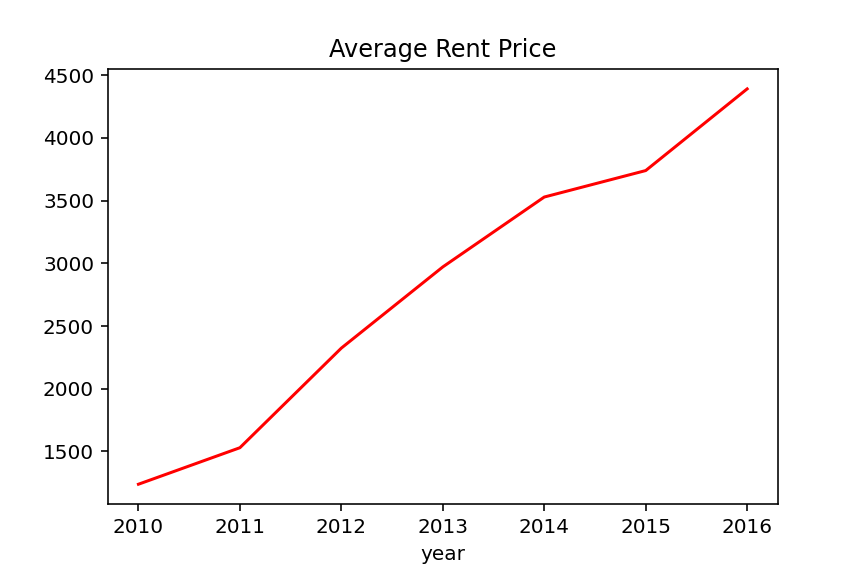
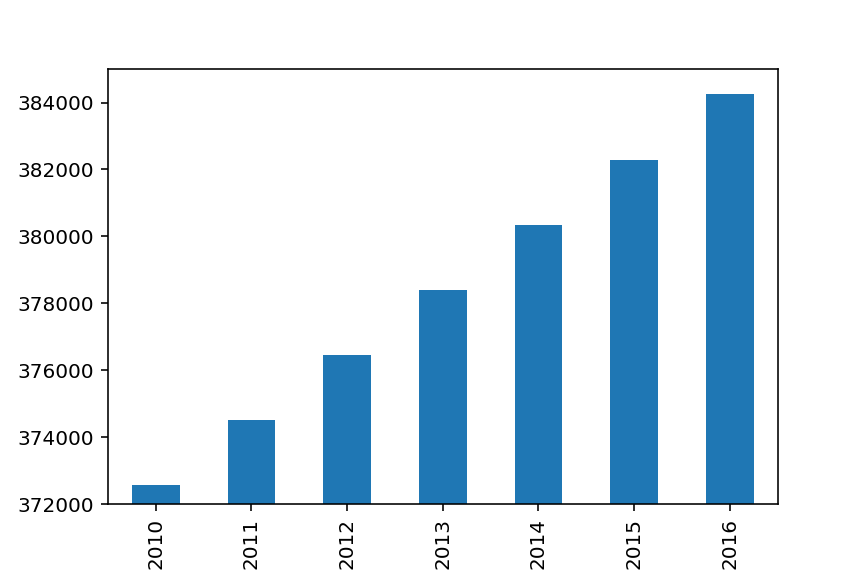
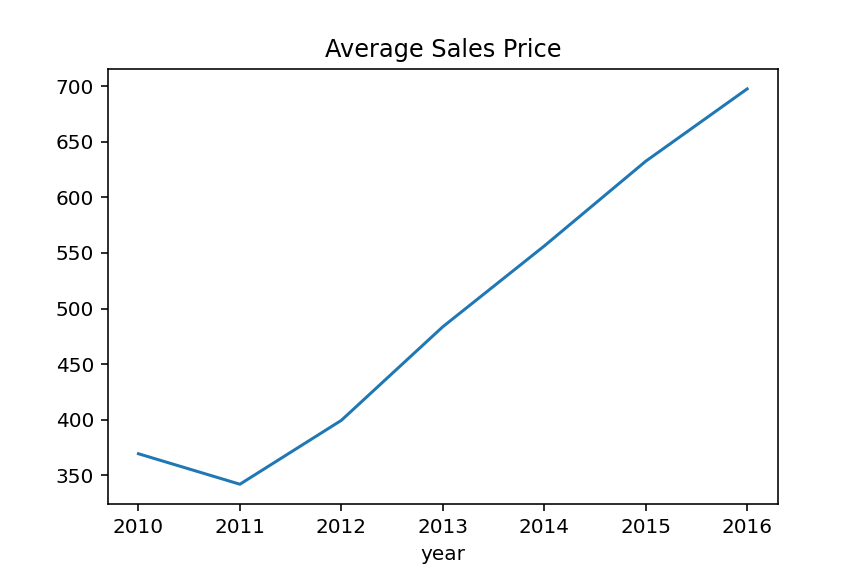

In [78]:
# Serve the# dashboard
dashboard.servable()

# Debugging

Note: Some of the Plotly express plots may not render in the notebook through the panel functions.

However, you can test each plot by uncommenting the following code

In [129]:
# housing_units_per_year()


In [ ]:
# average_gross_rent()


In [ ]:
# average_sales_price()



In [ ]:
# average_price_by_neighborhood()


In [ ]:
# top_most_expensive_neighborhoods()


In [ ]:
# most_expensive_neighborhoods_rent_sales()


In [130]:
# neighborhood_map().show()

